In [3]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = "F:/Oasis Infobyte_internship/Cleaning Data/AB_NYC_2019.csv"
df = pd.read_csv(file_path)

# Display the first few rows to understand the dataset
print("Initial dataset preview:")
df.head()

Initial dataset preview:


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [5]:
# Check data types to ensure they are appropriate
print("\nData types:")
print(df.dtypes)


Data types:
id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object


In [7]:
# Step 1: Data Integrity Check
# Ensure 'price' and 'minimum_nights' are numeric and positive
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['minimum_nights'] = pd.to_numeric(df['minimum_nights'], errors='coerce')

# Remove rows where 'price' or 'minimum_nights' are non-positive or NaN
df = df[(df['price'] > 0) & (df['minimum_nights'] > 0) & (df['price'].notna()) & (df['minimum_nights'].notna())]
print(f"\nRows after removing non-positive 'price' or 'minimum_nights': {df.shape[0]}")

# Validate 'latitude' and 'longitude' for NYC (approx. lat: 40.5 to 41.0, lon: -74.3 to -73.7)
df = df[(df['latitude'].between(40.5, 41.0)) & (df['longitude'].between(-74.3, -73.7))]
print(f"Rows after latitude/longitude validation: {df.shape[0]}")

# Ensure 'availability_365' is between 0 and 365
df = df[(df['availability_365'].between(0, 365))]
print(f"Rows after 'availability_365' validation: {df.shape[0]}")




Rows after removing non-positive 'price' or 'minimum_nights': 48884
Rows after latitude/longitude validation: 48883
Rows after 'availability_365' validation: 48883


In [9]:
# Step 2: Missing Data Handling
# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Handle missing 'name' and 'host_name' by filling with 'Unknown'
df['name'] = df['name'].fillna('Unknown')
df['host_name'] = df['host_name'].fillna('Unknown')

# Handle 'last_review' and 'reviews_per_month'
# Fill 'last_review' with a placeholder date and convert to datetime
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce').fillna('2009-01-01')

# Fill 'reviews_per_month' with 0 where there are no reviews
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)

# Verify missing values are handled
print("\nMissing values after handling:")
print(df.isnull().sum())




Missing values per column:
id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10050
reviews_per_month                 10050
calculated_host_listings_count        0
availability_365                      0
dtype: int64

Missing values after handling:
id                                0
name                              0
host_id                           0
host_name                         0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0

In [11]:
# Step 3: Duplicate Removal
# Check for duplicate rows
duplicates = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")
if duplicates > 0:
    df = df.drop_duplicates()

# Check for duplicate 'id' (each listing should be unique)
duplicate_ids = df['id'].duplicated().sum()
print(f"Number of duplicate IDs: {duplicate_ids}")
if duplicate_ids > 0:
    df = df.drop_duplicates(subset='id', keep='first')
print(f"Rows after duplicate removal: {df.shape[0]}")


Number of duplicate rows: 0
Number of duplicate IDs: 0
Rows after duplicate removal: 48883


In [13]:
# Step 4: Standardization
# Convert 'room_type' and 'neighbourhood_group' to title case for consistency
df['room_type'] = df['room_type'].str.title()
df['neighbourhood_group'] = df['neighbourhood_group'].str.title()

# Check unique values to ensure consistency
print("\nUnique 'neighbourhood_group' values:")
print(df['neighbourhood_group'].unique())
print("Unique 'room_type' values:")
print(df['room_type'].unique())


Unique 'neighbourhood_group' values:
['Brooklyn' 'Manhattan' 'Queens' 'Staten Island' 'Bronx']
Unique 'room_type' values:
['Private Room' 'Entire Home/Apt' 'Shared Room']


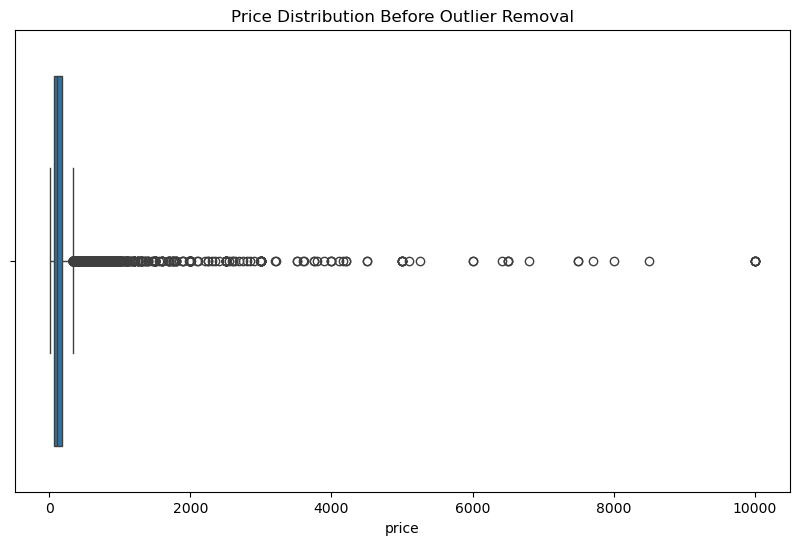

Rows after outlier removal in 'price': 48016


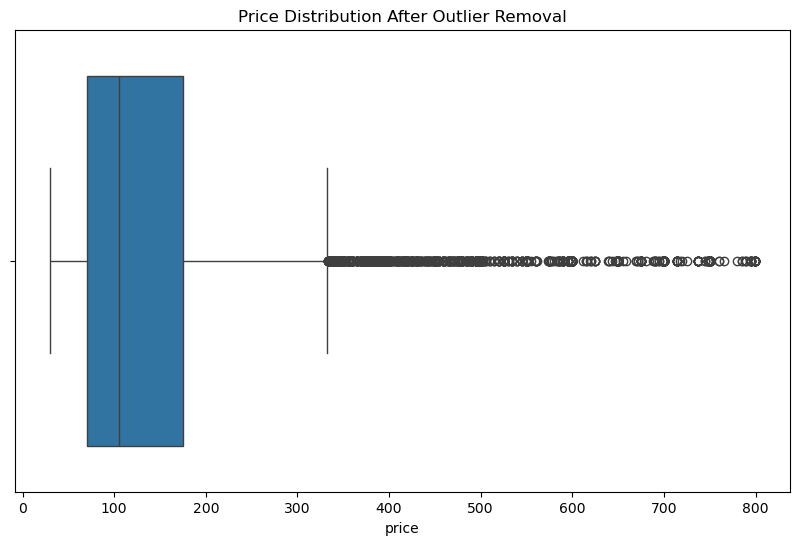

In [15]:
# Step 5: Outlier Detection
# Visualize 'price' distribution
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['price'])
plt.title('Price Distribution Before Outlier Removal')
plt.show()

# Remove outliers in 'price' using the 1st and 99th percentiles
lower_bound = df['price'].quantile(0.01)
upper_bound = df['price'].quantile(0.99)
df = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]
print(f"Rows after outlier removal in 'price': {df.shape[0]}")

# Visualize 'price' distribution after outlier removal
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['price'])
plt.title('Price Distribution After Outlier Removal')
plt.show()



In [23]:
# Final Data Check
print("\nFinal dataset info:")
print(df.info())
print("\nFinal dataset preview:")
print(df.head())
# Save the cleaned dataset
cleaned_file_path ="F:/Oasis Infobyte_internship/Cleaning Data/AB_NYC_2019_cleaned.csv"
df.to_csv(cleaned_file_path, index=False)
print(f"\nCleaned dataset saved to: {cleaned_file_path}")


Final dataset info:
<class 'pandas.core.frame.DataFrame'>
Index: 48016 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              48016 non-null  int64         
 1   name                            48016 non-null  object        
 2   host_id                         48016 non-null  int64         
 3   host_name                       48016 non-null  object        
 4   neighbourhood_group             48016 non-null  object        
 5   neighbourhood                   48016 non-null  object        
 6   latitude                        48016 non-null  float64       
 7   longitude                       48016 non-null  float64       
 8   room_type                       48016 non-null  object        
 9   price                           48016 non-null  int64         
 10  minimum_nights                  48016 non-null  int64 

In [29]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
# Step 1: Load the dataset
# Adjust the file path if necessary
# List of file names
file_names = [
    "CAvideos.csv",
    "FRvideos.csv",
    "GBvideos.csv",
    "INvideos.csv",
    "JPvideos.csv",
    "RUvideos.csv",
    "USvideos.csv"
]

# Common path
common_path = r"F:\Oasis Infobyte_internship\Cleaning Data"
# Load a specific file, for example the first one
file_path = os.path.join(common_path, file_names[0])
df = pd.read_csv(file_path)

# Display the first few rows to understand the dataset
print("Initial dataset preview:")
df.head()
      

Initial dataset preview:


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,n1WpP7iowLc,17.14.11,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,10,2017-11-10T17:00:03.000Z,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",17158579,787425,43420,125882,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,False,False,False,Eminem's new track Walk on Water ft. Beyoncé i...
1,0dBIkQ4Mz1M,17.14.11,PLUSH - Bad Unboxing Fan Mail,iDubbbzTV,23,2017-11-13T17:00:00.000Z,"plush|""bad unboxing""|""unboxing""|""fan mail""|""id...",1014651,127794,1688,13030,https://i.ytimg.com/vi/0dBIkQ4Mz1M/default.jpg,False,False,False,STill got a lot of packages. Probably will las...
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146035,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095828,132239,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...
4,2Vv-BfVoq4g,17.14.11,Ed Sheeran - Perfect (Official Music Video),Ed Sheeran,10,2017-11-09T11:04:14.000Z,"edsheeran|""ed sheeran""|""acoustic""|""live""|""cove...",33523622,1634130,21082,85067,https://i.ytimg.com/vi/2Vv-BfVoq4g/default.jpg,False,False,False,🎧: https://ad.gt/yt-perfect\n💰: https://atlant...


In [31]:
# Step 2: Data Integrity Check
# Ensure numeric columns are properly formatted and positive
numeric_cols = ['views', 'likes', 'dislikes', 'comment_count']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df[df[col] >= 0]  # Remove rows with negative or NaN values
print(f"\nRows after numeric column validation: {df.shape[0]}")

# Validate 'trending_d' and 'publish_time' as dates
df['trending_date'] = pd.to_datetime(df['trending_date'], format='%y.%d.%m', errors='coerce')
# Handle 'publish_time' which has mixed formats (e.g., "26 2017-11-1" or "DD.MM.YYYY-HH:MM:SS")
df['publish_time'] = df['publish_time'].str.extract(r'(\d{2}\.\d{2}\.\d{4})')  # Extract date part if present
df['publish_time'] = pd.to_datetime(df['publish_time'], format='%d.%m.%Y', errors='coerce')


Rows after numeric column validation: 40881


In [33]:
# Step 3: Missing Data Handling
# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Handle missing values
df['title'] = df['title'].fillna('Unknown')  # Fill missing titles
df['channel_title'] = df['channel_title'].fillna('[none]') if 'channel_title' in df.columns else df['channel_title'].fillna('[none]')  # Handle channel name
df['category_id'] = df['category_id'].fillna(0)  # Fill with 0 for unknown category
df['publish_time'] = df['publish_time'].fillna(pd.Timestamp('2008-01-01'))  # Placeholder for missing dates
df['trending_date'] = df['trending_date'].fillna(pd.Timestamp('2008-01-01'))  # Placeholder for missing trending dates
df['description'] = df['description'].fillna('No description')  # Fill missing descriptions
df['tags'] = df['tags'].fillna('')  # Empty string for missing tags

# Drop rows where critical columns are still NaN (e.g., 'video_id')
df = df.dropna(subset=['video_id'])
print("\nMissing values after handling:")
print(df.isnull().sum())


Missing values per column:
video_id                      0
trending_date                 0
title                         0
channel_title                 0
category_id                   0
publish_time              40881
tags                          0
views                         0
likes                         0
dislikes                      0
comment_count                 0
thumbnail_link                0
comments_disabled             0
ratings_disabled              0
video_error_or_removed        0
description                1296
dtype: int64

Missing values after handling:
video_id                  0
trending_date             0
title                     0
channel_title             0
category_id               0
publish_time              0
tags                      0
views                     0
likes                     0
dislikes                  0
comment_count             0
thumbnail_link            0
comments_disabled         0
ratings_disabled          0
video_error_or_removed 

In [35]:
# Step 4: Duplicate Removal
# Check for duplicate rows
duplicates = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")
if duplicates > 0:
    df = df.drop_duplicates()

# Ensure 'video_id' is unique
duplicate_ids = df['video_id'].duplicated().sum()
print(f"Number of duplicate 'video_id's: {duplicate_ids}")
if duplicate_ids > 0:
    df = df.drop_duplicates(subset='video_id', keep='first')
print(f"Rows after duplicate removal: {df.shape[0]}")


Number of duplicate rows: 0
Number of duplicate 'video_id's: 16454
Rows after duplicate removal: 24427


In [37]:
# Step 5: Standardization
# Standardize text columns to title case
df['title'] = df['title'].str.title()
df['channel_title'] = df['channel_title'].str.title()
df['description'] = df['description'].str.capitalize()

# Clean up 'category_id' (assuming it should be an integer)
df['category_id'] = df['category_id'].astype(int)

# Check unique values for consistency
print("\nUnique 'category_id' values:")
print(df['category_id'].unique())
print("Unique 'channel_title' values (sample):")
print(df['channel_title'].unique()[:5])  # Show first 5 for brevity


Unique 'category_id' values:
[10 23 24 25 22 26  1 28 20 17 29 15 19  2 27 43 30]
Unique 'channel_title' values (sample):
['Eminemvevo' 'Idubbbztv' 'Rudy Mancuso' 'Nigahiga' 'Ed Sheeran']


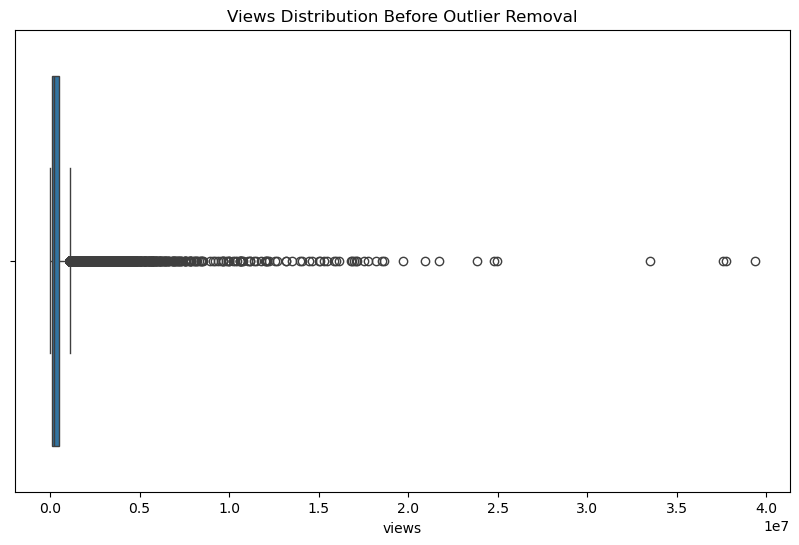

Rows after outlier removal in 'views': 23937


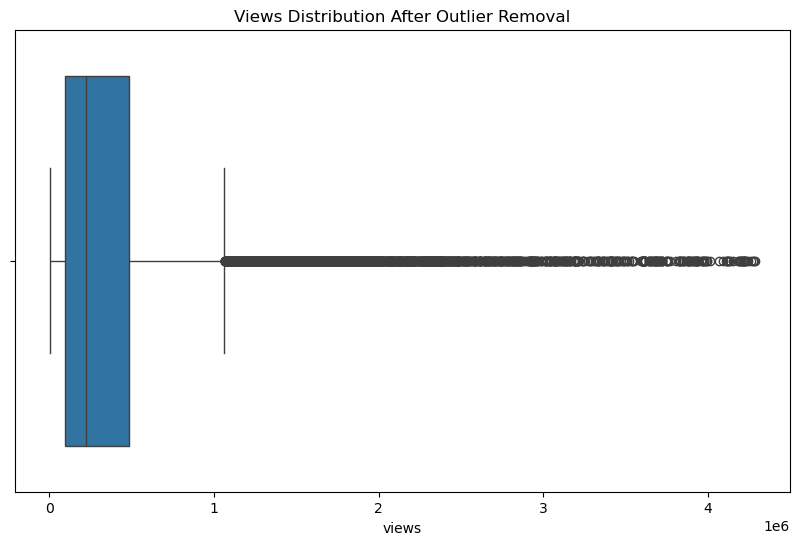


Final dataset info:
<class 'pandas.core.frame.DataFrame'>
Index: 23937 entries, 1 to 40880
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   video_id                23937 non-null  object        
 1   trending_date           23937 non-null  datetime64[ns]
 2   title                   23937 non-null  object        
 3   channel_title           23937 non-null  object        
 4   category_id             23937 non-null  int64         
 5   publish_time            23937 non-null  datetime64[ns]
 6   tags                    23937 non-null  object        
 7   views                   23937 non-null  float64       
 8   likes                   23937 non-null  float64       
 9   dislikes                23937 non-null  float64       
 10  comment_count           23937 non-null  float64       
 11  thumbnail_link          23937 non-null  object        
 12  comments_disabled       23937 

In [39]:
# Step 6: Outlier Detection
# Visualize 'views' distribution before outlier removal
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['views'])
plt.title('Views Distribution Before Outlier Removal')
plt.show()

# Remove outliers in 'views' using the 1st and 99th percentiles
lower_bound = df['views'].quantile(0.01)
upper_bound = df['views'].quantile(0.99)
df = df[(df['views'] >= lower_bound) & (df['views'] <= upper_bound)]
print(f"Rows after outlier removal in 'views': {df.shape[0]}")

# Visualize 'views' distribution after outlier removal
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['views'])
plt.title('Views Distribution After Outlier Removal')
plt.show()

# Step 7: Final Data Check
# Ensure data types are appropriate
expected_dtypes = {
    'video_id': 'object',
    'trending_d': 'datetime64[ns]',
    'title': 'object',
    'channel_title': 'object',
    'category_id': 'int64',
    'publish_time': 'datetime64[ns]',
    'views': 'float64',
    'likes': 'float64',
    'dislikes': 'float64',
    'comment_count': 'float64'
}
for col, dtype in expected_dtypes.items():
    if col in df.columns:
        df[col] = df[col].astype(dtype)
print("\nFinal dataset info:")
print(df.info())

# Display a preview of the cleaned dataset
print("\nCleaned dataset preview:")
print(df.head())

# Step 8: Save the cleaned dataset
cleaned_file_path = 'youtube_videos_cleaned.csv'
df.to_csv(cleaned_file_path, index=False)
print(f"\nCleaned dataset saved to: {cleaned_file_path}")